In [25]:
"""

Neural network to classify user
In the case  study of IF29 class
author : Nathan Davouse

"""

import matplotlib.pyplot as plt
#connect from Mongo DB and import it on pandas
from pymongo import MongoClient
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

client = MongoClient("localhost", 27017)
db = client["IF29"]
collec = db.user_label #whole database
data = pd.DataFrame(list(collec.find()))

In [26]:
#Normalize data
features = ["verified", "friend_nb", "listed_nb", "follower_nb", 
            "favorites_nb", "len_description",
            "tweet_nb","hash_avg","at_avg","tweet_user_count",
            'tweet_frequency', 'friend_frequency',"visibility","Aggressivity"]
X = data[features]
Y = data[["label"]]

In [27]:
#normalize data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.set_output(transform="pandas")
X_sc = scaler.fit_transform(X)

X_sc

,verified,friend_nb,listed_nb,follower_nb,favorites_nb,len_description,tweet_nb,hash_avg,at_avg,tweet_user_count,tweet_frequency,friend_frequency,visibility,Aggressivity
0,1.0,0.001585,0.023217,0.002083,7.859111e-03,0.721698,0.0007,0.04,0.051282,7.480728e-03,0.005575,0.000269,0.005783,0.064103
1,0.0,0.000122,0.000102,0.000015,1.841124e-03,0.080189,0.0000,0.00,0.076923,1.364499e-03,0.001019,0.000021,0.001035,0.038462
2,0.0,0.000308,0.000962,0.000108,2.691510e-02,0.646226,0.0000,0.00,0.000000,3.335829e-03,0.002491,0.000052,0.002532,0.000000
3,1.0,0.000700,0.009639,0.000509,3.544339e-03,0.547170,0.0000,0.04,0.000000,1.557536e-03,0.001163,0.000119,0.001255,0.038462
4,0.0,0.000595,0.001372,0.000104,7.009540e-03,0.330189,0.0000,0.12,0.076923,1.314893e-03,0.000982,0.000101,0.001060,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843434,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0000,0.12,0.076923,2.244611e-07,0.000078,0.000000,0.000078,0.153846
1843435,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0000,0.12,0.076923,4.489222e-07,0.000131,0.000000,0.000131,0.153846
1843436,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0000,0.16,0.076923,1.458997e-06,0.000366,0.000000,0.000366,0.192308
1843437,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0000,0.12,0.076923,0.000000e+00,0.000026,0.000000,0.000026,0.153846


In [28]:
Y["label"].unique()

array([1, 0, 2], dtype=int64)

In [29]:
# remove Vp & Ap from training
X_plot = X_sc[["visibility", "Aggressivity"]].copy()
X_sc_removed = X_sc.drop(["visibility", "Aggressivity"], axis=1)
# Slice and correct label
X_train = X_sc_removed[Y.label != 1]
Y_train = Y[Y.label != 1]
#Y_train.loc[Y_train.label ==2] = 1
#Y_train[Y_train.label == 2] = 1
# Split data


Y_train = Y_train.iloc[:10000]
X_train = X_train.iloc[:10000]

num_twos = (Y_train == 2).sum().item()
print(num_twos)

print(Y_train.shape)
print(X_train.shape)


from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.30)
X_train = torch.FloatTensor(X_train.values)
x_test = torch.FloatTensor(X_test.values)
Y_train = torch.LongTensor(Y_train.values)
y_test = torch.LongTensor(Y_test.values)

229
(10000, 1)
(10000, 12)


In [30]:
"""Create and train the neural network"""
#héritier de torch.nn.Module
class Model(torch.nn.Module):

    #constructeur, input_features nombre de variables explicatives
    def __init__(self, input_features, hidden_sizes, output_classes):
        #appel du constructeur de l'ancêtre
        super().__init__()
        #couche d'entrée (p variables) vers première couche cachée
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_features, hidden_sizes[0]))
        
        # Ajout des autres couches cachées
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Dernière couche cachée vers la couche de sortie
        self.output_layer = nn.Linear(hidden_sizes[-1], output_classes)
    
    #calcul de la sortie du réseau
    #à partir d'une matrice x en entrée
    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        out = self.output_layer(x)
        return out
    

In [55]:
#Paramétrage    
input_size = X_sc_removed.shape[1]
hidden_size = [100, 50, 20]
n_epochs = 150

output_classes = data['label'].nunique()


In [56]:
#création du modèle
model = Model(input_size, hidden_size, output_classes)
type(model)


__main__.Model

In [57]:
#optimisation modèle
criterion = torch.nn.CrossEntropyLoss()
#critere_ps = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [58]:
def calc_accuracy(model, X, y_true):
    # Mettre le modèle en mode évaluation
    model.eval()
    # Pas besoin de calculer les gradients lors de l'évaluation
    with torch.no_grad():
        # Obtenir les prédictions du modèle
        y_pred_prob = F.softmax(model(X), dim=1)
        # Obtenir les classes prédites en prenant l'indice de la classe avec la probabilité maximale
        _, y_pred = torch.max(y_pred_prob, 1)
        # Calculer l'accuracy
        correct = (y_pred == y_true).sum().item()
        total = y_true.size(0)
        accuracy = correct / total
    return accuracy





In [59]:
print(X_train.shape)

yPred = model(X_train)
yPred


torch.Size([7000, 12])


tensor([[ 0.1251,  0.2430, -0.1974],
        [ 0.1260,  0.2438, -0.1981],
        [ 0.1229,  0.2421, -0.1946],
        ...,
        [ 0.1247,  0.2429, -0.1970],
        [ 0.1210,  0.2409, -0.1926],
        [ 0.1270,  0.2408, -0.1943]], grad_fn=<AddmmBackward0>)

In [60]:
#entrainement
def train_session(X_train, Y_train, x_test, y_test, classifier, criterion, optimizer, n_epochs):
    losses = np.zeros(n_epochs)
    accuracies_train = np.zeros(n_epochs)
    accuracies_test = np.zeros(n_epochs)

    for iter in range(n_epochs):
        optimizer.zero_grad()
        yPred = classifier(X_train)
        loss = criterion(yPred.squeeze(), Y_train.squeeze())
        losses[iter] = loss.item()
        loss.backward()
        optimizer.step()

        # Calculer l'accuracy sur les données d'entraînement
        accuracy_train = calc_accuracy(classifier, X_train, Y_train)
        accuracies_train[iter] = accuracy_train

        # Calculer l'accuracy sur les données de test
        accuracy_test = calc_accuracy(classifier, x_test, y_test)
        accuracies_test[iter] = accuracy_test
        
    return losses, accuracies_train, accuracies_test


In [61]:
#entrainement du modèle
pertes, accuracies_train, accuracies_test = train_session(X_train, Y_train, x_test, y_test, model, criterion, optimizer, n_epochs)


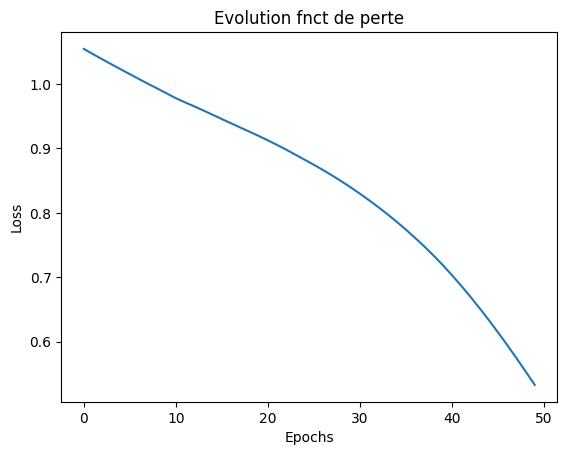

In [62]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,pertes.shape[0]),pertes)
plt.title("Evolution fnct de perte")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [63]:
with torch.no_grad():
    
    # Passer les données d'évaluation à travers le modèle pour obtenir les prédictions
    y_eval = model(x_test)

    # Calculer la perte en utilisant la fonction de perte
    loss = criterion(y_eval, y_test.squeeze())

print(loss)

tensor(0.5126)


def accuracy_by_epoch(X_train, Y_train, x_test, y_test, model, criterion, optimizer, n_epochs):
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(n_epochs):
        # Entraînement du modèle pour une epoch
        train_session(X_train, Y_train, model, criterion, optimizer, 1)
        
        # Calcul de l'accuracy sur l'ensemble d'entraînement
        train_accuracy = calculate_accuracy(X_train, Y_train, model)
        train_accuracies.append(train_accuracy)
        
        # Calcul de l'accuracy sur l'ensemble de test
        test_accuracy = calculate_accuracy(x_test, y_test, model)
        test_accuracies.append(test_accuracy)
        
    return train_accuracies, test_accuracies

In [64]:
print(accuracies_train)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.77714286e-01 4.57570286e+02
 1.95249543e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03 6.84400000e+03 6.84400000e+03
 6.84400000e+03 6.84400000e+03]


In [65]:
print(accuracies_test)

[   0.            0.            0.            0.            0.
    0.            0.          232.20866667  846.87866667 2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.
 2927.         2927.         2927.         2927.         2927.        ]


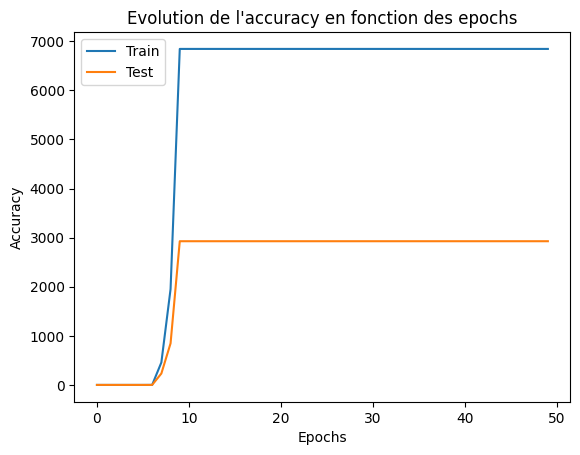

In [66]:
plt.plot(np.arange(0, accuracies_train.shape[0]), accuracies_train, label='Train')
plt.plot(np.arange(0, accuracies_test.shape[0]), accuracies_test, label='Test')
plt.title("Evolution de l'accuracy en fonction des epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()